# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, filtfilt, welch
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
!pip install mne
from mne.decoding import CSP
import mne
from google.colab import drive
drive.mount('/content/drive')
subject_aa='drive/My Drive/Motor Imagery/data_set_IVa_aa.mat'
subject_al='drive/My Drive/Motor Imagery/data_set_IVa_al.mat'
subject_av='drive/My Drive/Motor Imagery/data_set_IVa_av.mat'
subject_aw='drive/My Drive/Motor Imagery/data_set_IVa_aw.mat'
subject_ay='drive/My Drive/Motor Imagery/data_set_IVa_ay.mat'

# Dataset Exploration

In [2]:
subject_aa=loadmat(subject_aa)
subject_al=loadmat(subject_al)
subject_av=loadmat(subject_av)
subject_aw=loadmat(subject_aw)
subject_ay=loadmat(subject_ay)


In [ ]:
subject_aa.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'nfo', 'cnt'])

In [25]:
subjects = [subject_aa, subject_al, subject_av, subject_aw, subject_ay]

def extract_pos_y(mrk):
    """Extract raw positions + labels (including NaNs)."""
    m = mrk[0,0]
    pos = m[0][0]
    y   = m[1][0]
    return pos, y

all_cnt = []
all_pos = []
all_y = []
cum_samples = 0

print("Merging subjects...\n")

for i, subj in enumerate(subjects):
    cnt = subj["cnt"]
    pos, y = extract_pos_y(subj["mrk"])

    print(f"Subject {i+1}: cnt={cnt.shape}, trials={len(y)}, nan_test={np.isnan(y).sum()}")

    adj_pos = pos + cum_samples

    all_cnt.append(cnt)
    all_pos.append(adj_pos)
    all_y.append(y)

    cum_samples += cnt.shape[0]

merged_cnt = np.vstack(all_cnt)
merged_pos = np.concatenate(all_pos)
merged_y = np.concatenate(all_y)

print("\n--- MERGED SUMMARY ---")
print("merged_cnt:", merged_cnt.shape)
print("merged_pos:", merged_pos.shape)
print("merged_y:", merged_y.shape)
print("Total trials:", len(merged_y))
print("NaN test trials:", np.isnan(merged_y).sum())
print("Class 1 trials:", np.sum(merged_y == 1))
print("Class 2 trials:", np.sum(merged_y == 2))


className = subjects[0]["mrk"][0,0][2]

merged_mrk = np.empty((1,1), dtype=[("pos", "O"), ("y", "O"), ("className", "O")])
merged_mrk[0,0] = (
    merged_pos.reshape(1,-1).astype(np.int32),
    merged_y.reshape(1,-1),
    className
)


merged_data = {
    "cnt": merged_cnt,
    "mrk": merged_mrk,
    "nfo": subjects[0]["nfo"],
    "__header__": subjects[0]["__header__"],
    "__version__": subjects[0]["__version__"],
    "__globals__": subjects[0]["__globals__"]
}

print("\nMERGE COMPLETE: merged_data ready!")


Merging subjects...

Subject 1: cnt=(298458, 118), trials=280, nan_test=112
Subject 2: cnt=(283574, 118), trials=280, nan_test=56
Subject 3: cnt=(283042, 118), trials=280, nan_test=196
Subject 4: cnt=(282838, 118), trials=280, nan_test=224
Subject 5: cnt=(283562, 118), trials=280, nan_test=252

--- MERGED SUMMARY ---
merged_cnt: (1431474, 118)
merged_pos: (1400,)
merged_y: (1400,)
Total trials: 1400
NaN test trials: 840
Class 1 trials: 282
Class 2 trials: 278

MERGE COMPLETE: merged_data ready!


In [ ]:
merged_data['mrk']['y'][0][0][0][:1000]


array([ 1.,  1.,  2.,  1.,  1.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,
        1.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  2.,
        2.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,
        1.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,
        1.,  1.,  1.,  1.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,  1.,  1.,
        1.,  2.,  2.,  1.,  2.,  2.,  2.,  1.,  1.,  2.,  1.,  1.,  2.,
        1.,  2.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,
        2.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  2.,
        2.,  2.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,
        1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  1.,  1.,
        1.,  2.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,
        2.,  1.,  1.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
        2.,  1.,  2.,  2.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,  2., nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

# Data Preprocessing

In [4]:
merged_cnt = merged_cnt * 0.1


In [26]:
fs = merged_data['nfo']['fs'][0][0][0][0]

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass(data, lowcut=8, highcut=30, fs=100):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data, axis=0)

filtered_cnt = apply_bandpass(merged_cnt, lowcut=8, highcut=30, fs=fs)

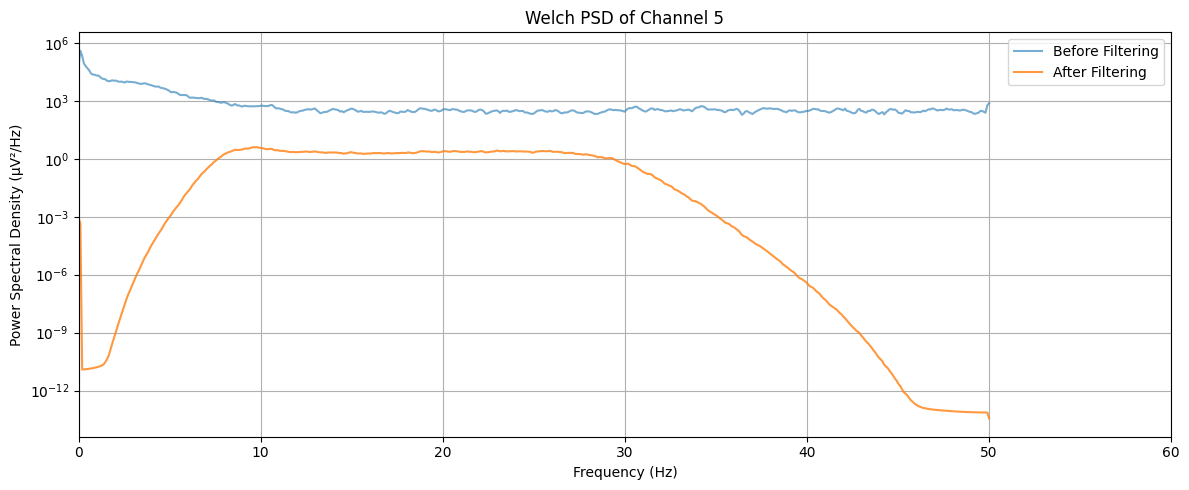

In [6]:
channel_index = 5
raw_signal = cnt[:, channel_index]
filtered_signal = filtered_cnt[:, channel_index]

f_raw, psd_raw = welch(raw_signal, fs=fs, nperseg=1024)
f_filt, psd_filt = welch(filtered_signal, fs=fs, nperseg=1024)

plt.figure(figsize=(12, 5))
plt.semilogy(f_raw, psd_raw, label='Before Filtering', alpha=0.6)
plt.semilogy(f_filt, psd_filt, label='After Filtering', alpha=0.8)
plt.xlim(0, 60)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.title(f"Welch PSD of Channel {channel_index}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


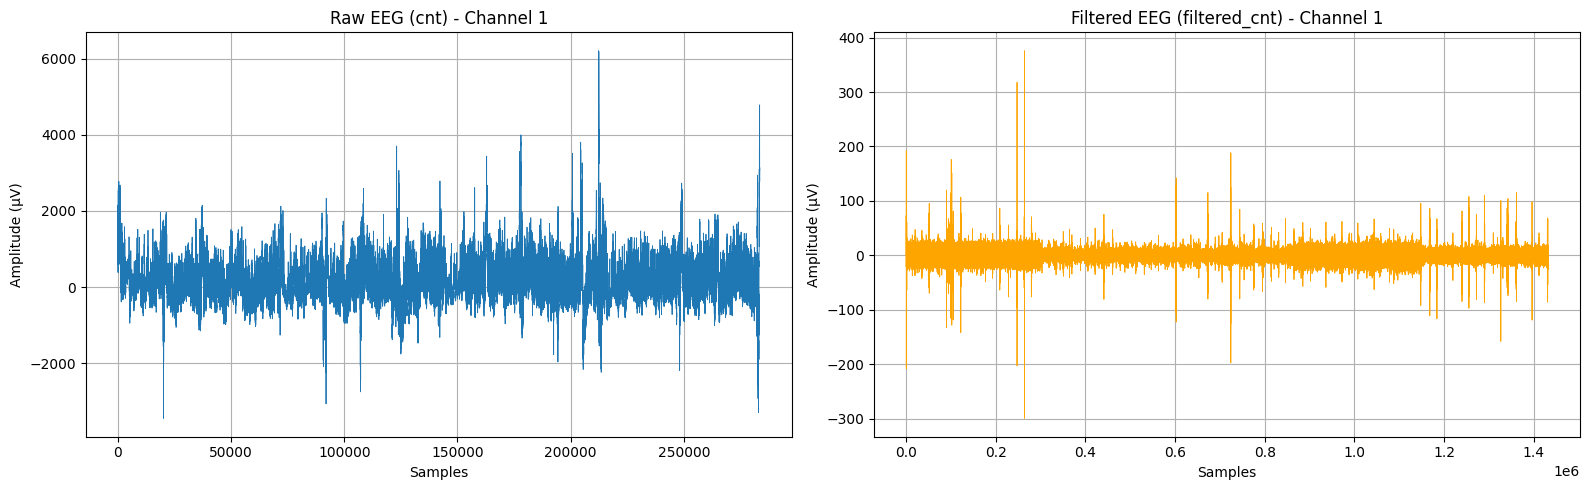

In [7]:
channel = 1

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(cnt[:, channel], linewidth=0.6)
plt.title(f"Raw EEG (cnt) - Channel {channel}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(filtered_cnt[:, channel], linewidth=0.6, color='orange')
plt.title(f"Filtered EEG (filtered_cnt) - Channel {channel}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.grid(True)

plt.tight_layout()
plt.show()



In [8]:
mrk = {
    'pos': merged_data['mrk']['pos'][0][0].flatten(),
    'y': merged_data['mrk']['y'][0][0].flatten()
}

In [9]:
mrk_y=mrk['y']
mrk_pos=mrk['pos']

In [11]:
y = mrk_y.flatten()

labeled_idx = np.where(~np.isnan(y))[0]

unlabeled_idx = np.where(np.isnan(y))[0]

print("Labeled trials:", len(labeled_idx))
print("Unlabeled trials:", len(unlabeled_idx))

pos_labeled = mrk_pos[labeled_idx]
pos_unlabeled = mrk_pos[unlabeled_idx]

y_labeled = y[labeled_idx].astype(int)


Labeled trials: 560
Unlabeled trials: 840


In [27]:
def create_epochs(cnt, positions, fs, tmin=0.6, tmax=3.7):
    samples_before = int(tmin * fs)
    samples_after  = int(tmax * fs)
    window_size    = samples_after - samples_before

    epochs = []
    for p in positions:
        start = p + samples_before
        stop  = p + samples_after
        epochs.append(cnt[start:stop])
    return np.array(epochs)


X_labeled = create_epochs(filtered_cnt, pos_labeled, fs)
X_unlabeled = create_epochs(filtered_cnt, pos_unlabeled, fs)

print(X_labeled.shape, y_labeled.shape)
print(X_unlabeled.shape)


(560, 310, 118) (560,)
(840, 310, 118)


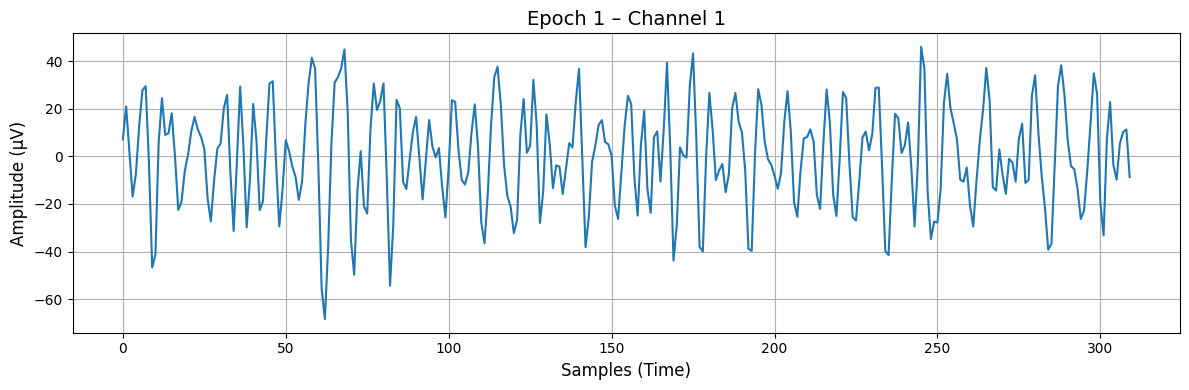

In [ ]:
epoch_idx = 0
channel_idx = 0

epoch = X_labeled[epoch_idx]

plt.figure(figsize=(12, 4))
plt.plot(epoch[:, channel_idx])

plt.title(f"Epoch {epoch_idx+1} – Channel {channel_idx+1}", fontsize=14)
plt.xlabel("Samples (Time)", fontsize=12)
plt.ylabel("Amplitude (µV)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
clab_raw = merged_data['nfo']['clab'][0][0]
if clab_raw.shape[0] == 1:
    clab_raw = clab_raw[0]
clab = [str(ch[0]) for ch in clab_raw]

PSD ANALYSIS - RIGHT HAND VS FOOT
Selected channel: Fp1 (index: 0)

Data shape: (560, 310, 118)
Right hand epochs: (282, 310, 118)
Foot epochs: (278, 310, 118)

Computing PSD for channel Fp1...


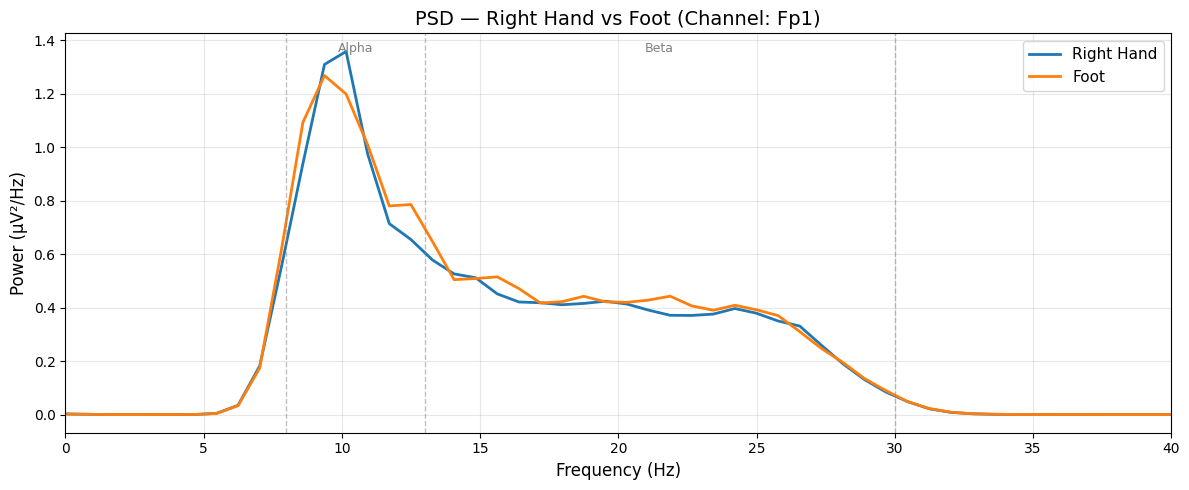

In [14]:
print("="*60)
print("PSD ANALYSIS - RIGHT HAND VS FOOT")
print("="*60)

channel_name = 'Fp1'

try:
    channel_idx = clab.index(channel_name)
    print(f"Selected channel: {channel_name} (index: {channel_idx})")
except ValueError:
    print(f"ERROR: Channel '{channel_name}' not found!")
    print(f"Available motor channels: {[ch for ch in clab if 'C' in ch.upper()]}")
    raise

print(f"\nData shape: {X_labeled.shape}")
right_hand_epochs = X_labeled[y_labeled == 1]
foot_epochs       = X_labeled[y_labeled == 2]

print(f"Right hand epochs: {right_hand_epochs.shape}")
print(f"Foot epochs: {foot_epochs.shape}")

fs = 100

def compute_mean_psd(epochs, fs, channel):
    """Compute mean PSD across epochs for a single channel"""
    psds = []
    for ep in epochs:
        f, Pxx = welch(ep[:, channel], fs=fs, nperseg=128)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)

print(f"\nComputing PSD for channel {channel_name}...")
f, psd_right = compute_mean_psd(right_hand_epochs, fs, channel_idx)
_, psd_foot  = compute_mean_psd(foot_epochs, fs, channel_idx)


plt.figure(figsize=(12, 5))
plt.plot(f, psd_right, label="Right Hand", linewidth=2, )
plt.plot(f, psd_foot,  label="Foot", linewidth=2,)

plt.title(f"PSD — Right Hand vs Foot (Channel: {channel_name})",
          fontsize=14,)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Power (µV²/Hz)", fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 40)

plt.axvline(x=8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=13, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.text(10.5, plt.ylim()[1]*0.95, 'Alpha', ha='center', fontsize=9, color='gray')
plt.text(21.5, plt.ylim()[1]*0.95, 'Beta', ha='center', fontsize=9, color='gray')

plt.tight_layout()


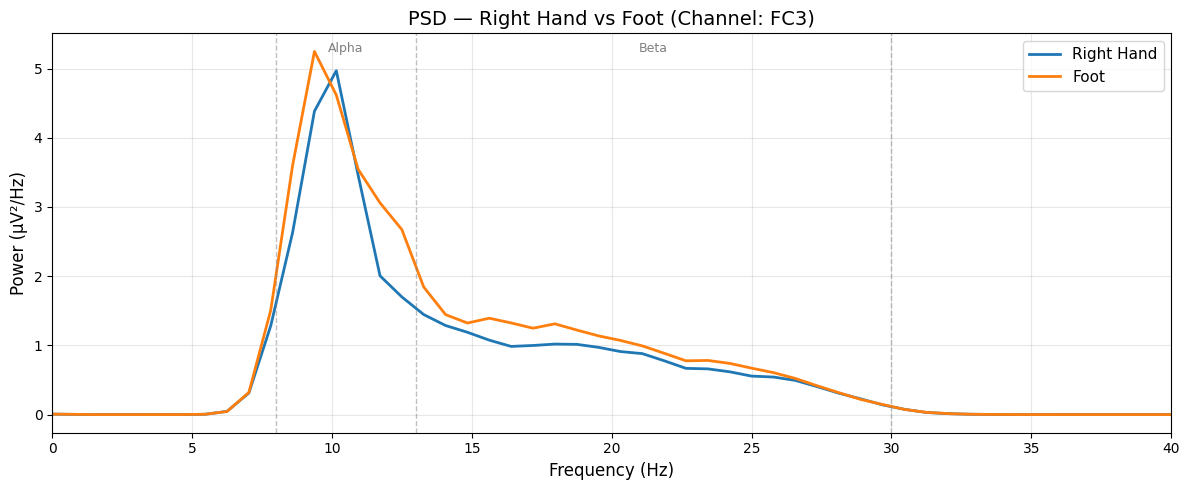

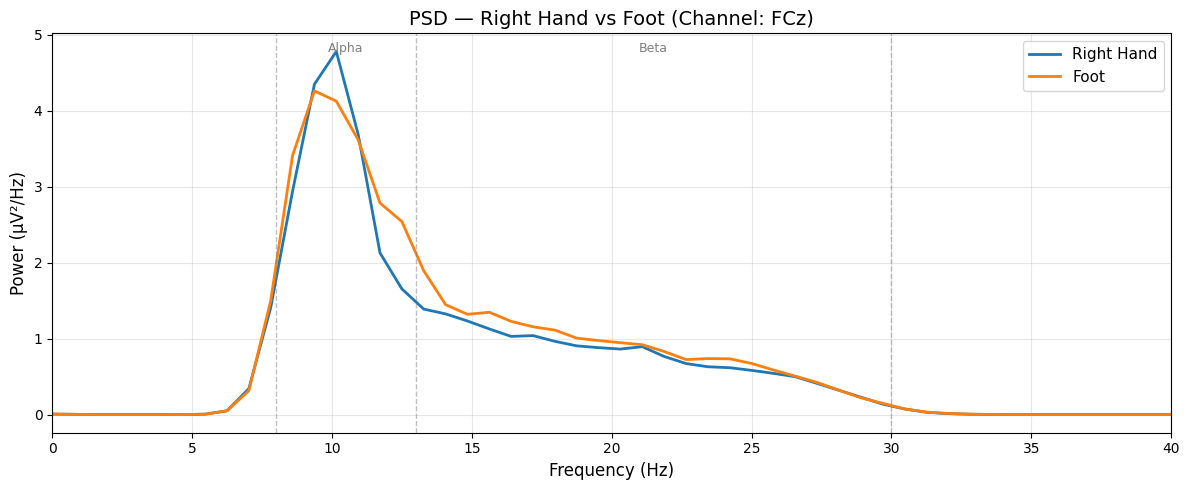

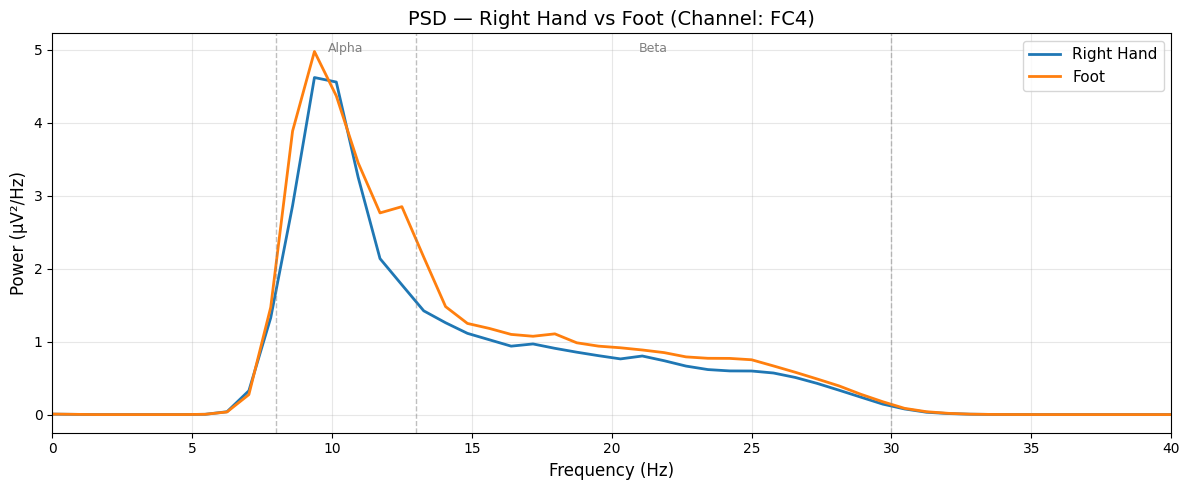

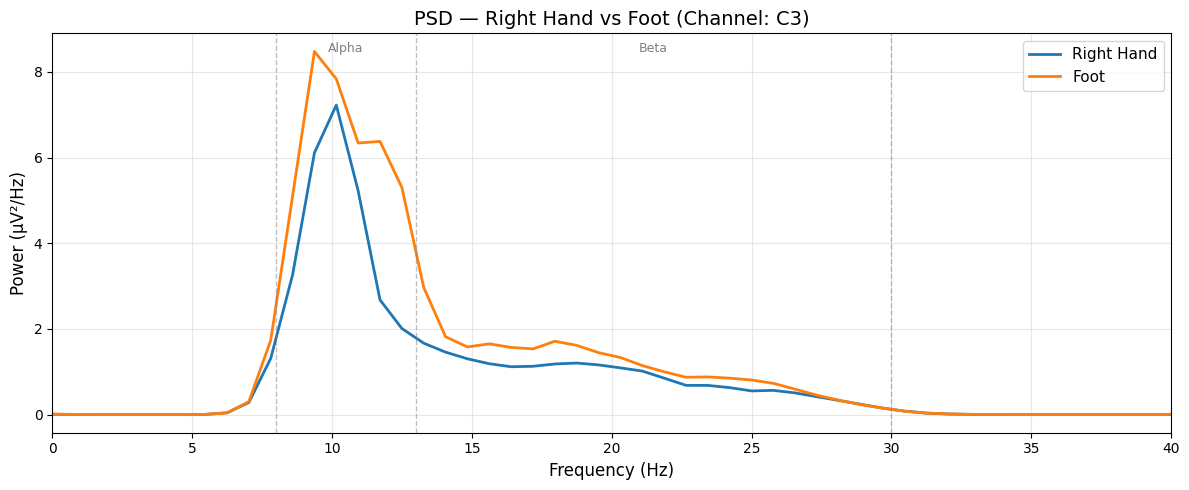

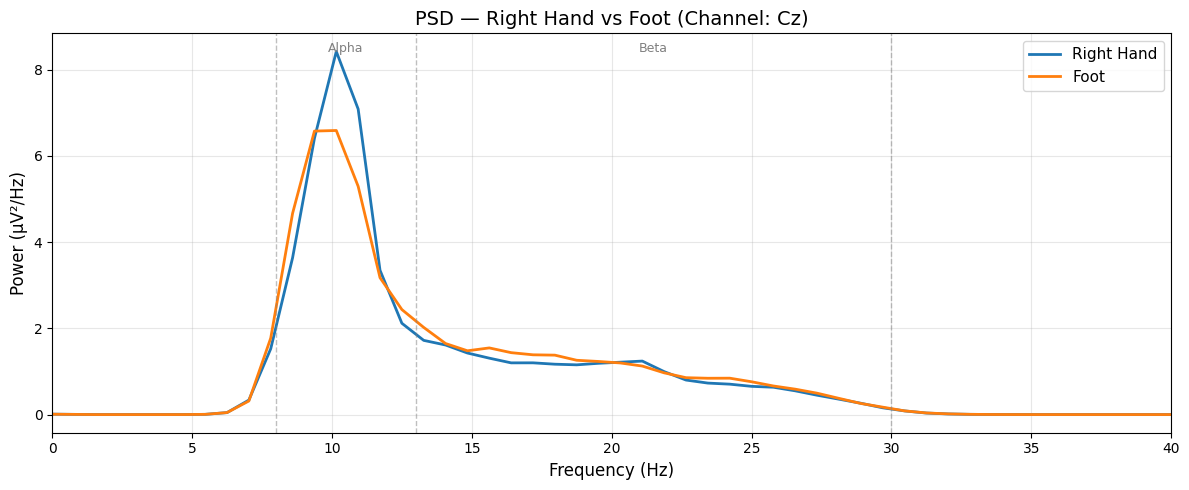

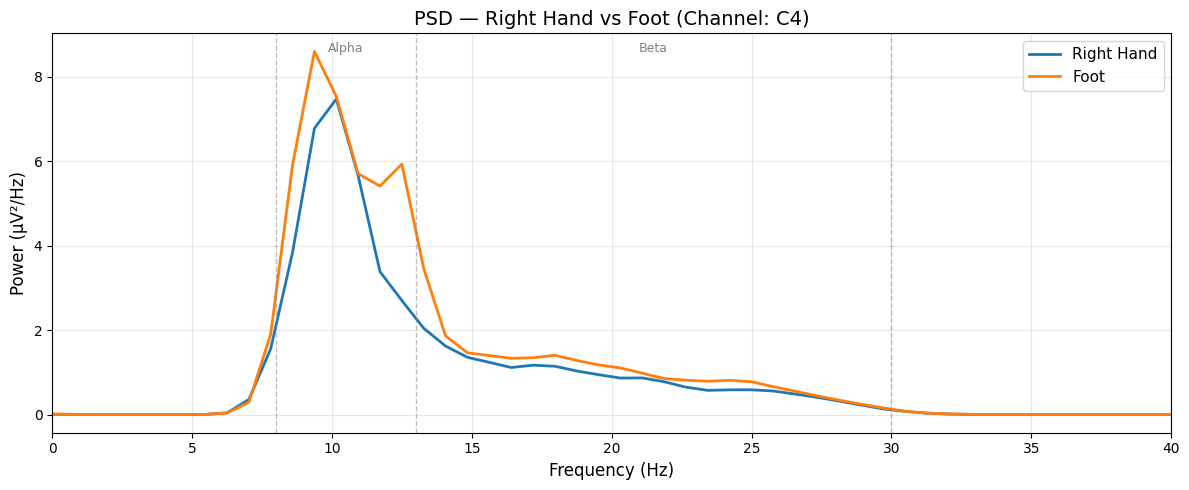

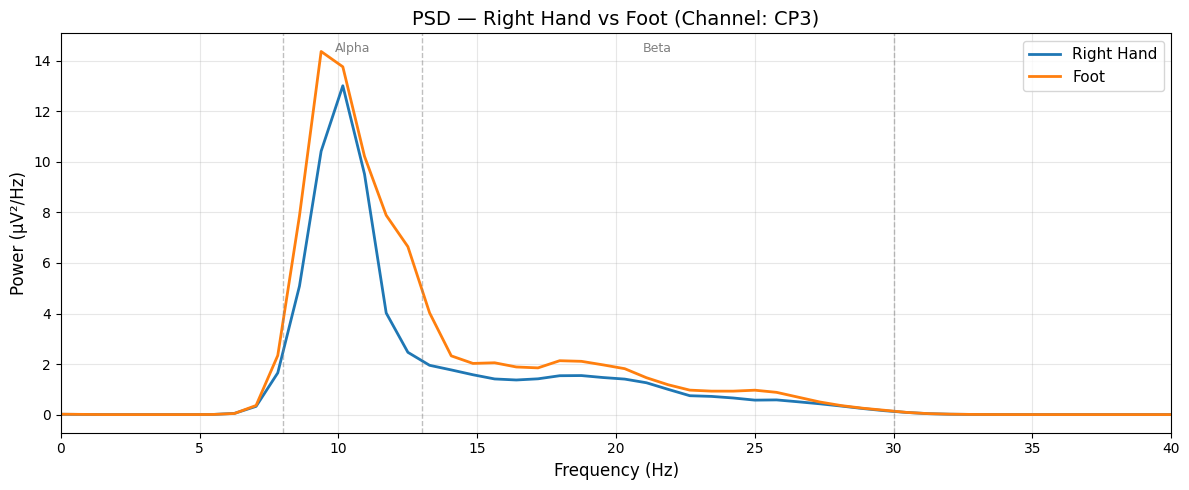

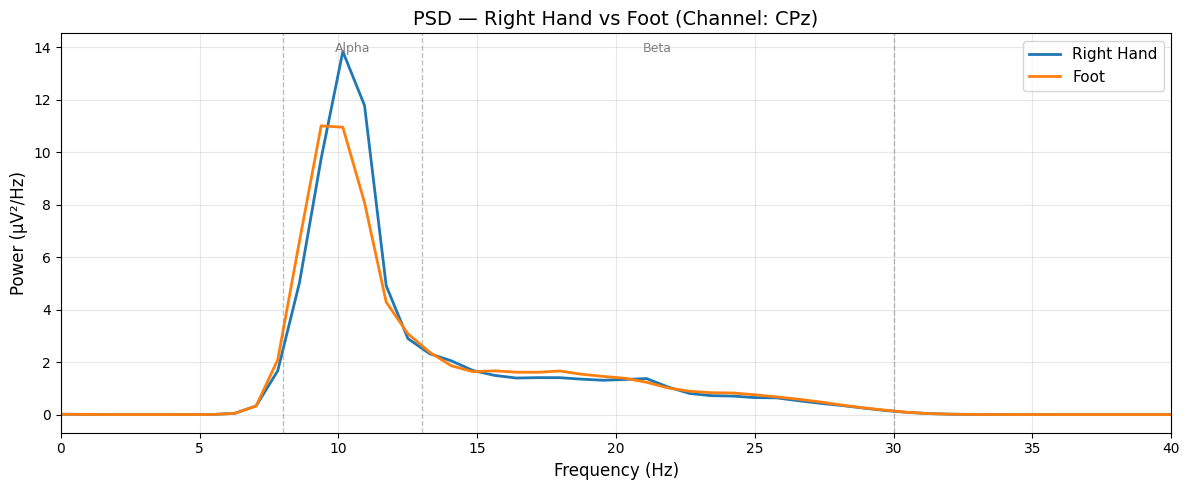

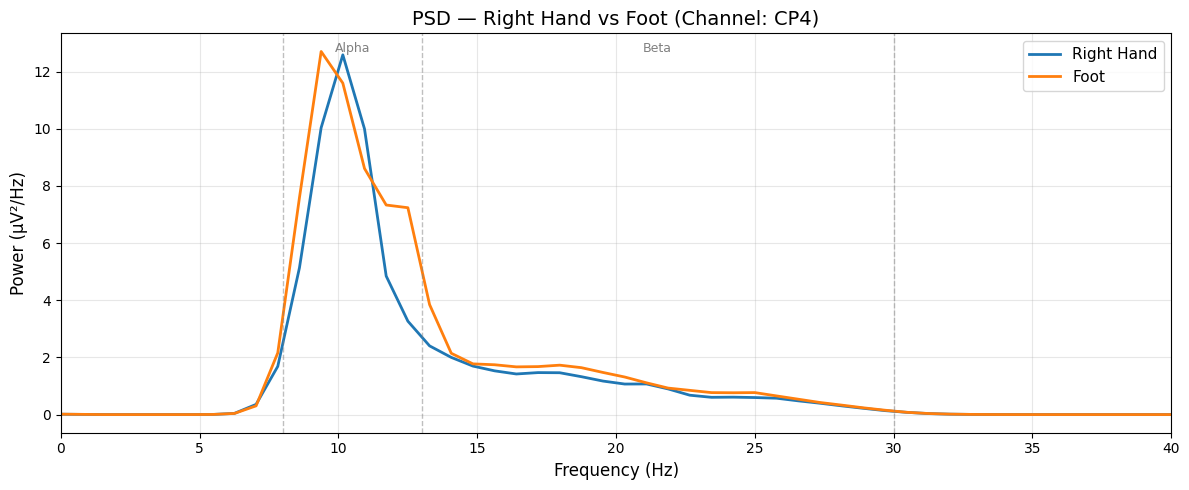

In [15]:
target_names = ["C3", "C4", "Cz", "FC3", "FC4", "FCz", "CP3", "CP4", "CPz"]

target_names_lower = [t.lower() for t in target_names]


clab_lower = [label.lower() for label in clab]


motor_channel_indices = [
    i for i, label_lower in enumerate(clab_lower)
    if label_lower in target_names_lower
]


right_hand_epochs = X_labeled[y_labeled == 1]
foot_epochs       = X_labeled[y_labeled == 2]

fs = 100

def compute_mean_psd(epochs, fs, ch):
    psds = []
    for ep in epochs:
        f, Pxx = welch(ep[:, ch], fs=fs, nperseg=128)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)



for i, ch_global_index in enumerate(motor_channel_indices):
    ch_name = clab[ch_global_index]

    f, psd_right = compute_mean_psd(right_hand_epochs, fs, ch_global_index)
    _, psd_foot  = compute_mean_psd(foot_epochs, fs, ch_global_index)

    plt.figure(figsize=(12, 5))
    plt.plot(f, psd_right, label="Right Hand", linewidth=2, )
    plt.plot(f, psd_foot,  label="Foot", linewidth=2,)

    plt.title(f"PSD — Right Hand vs Foot (Channel: {ch_name})",
              fontsize=14,)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Power (µV²/Hz)", fontsize=12)
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 40)

    plt.axvline(x=8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=13, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    plt.text(10.5, plt.ylim()[1]*0.95, 'Alpha', ha='center', fontsize=9, color='gray')
    plt.text(21.5, plt.ylim()[1]*0.95, 'Beta', ha='center', fontsize=9, color='gray')

    plt.tight_layout()
    plt.show()

# Model Evaluation and Training

In [16]:
true_labels_aa=loadmat('/content/true_labels_ay.mat')
true_labels_al=loadmat('/content/true_labels_al.mat')
true_labels_av=loadmat('/content/true_labels_av.mat')
true_labels_aw=loadmat('/content/true_labels_aw.mat')
true_labels_ay=loadmat('/content/true_labels_ay.mat')



In [17]:
true_y_aa=true_labels_aa['true_y'][0]
true_y_al=true_labels_al['true_y'][0]
true_y_av=true_labels_av['true_y'][0]
true_y_aw=true_labels_aw['true_y'][0]
true_y_ay=true_labels_ay['true_y'][0]

In [21]:
true_labels_dict = {
    'aa': true_labels_aa,
    'al': true_labels_al,
    'av': true_labels_av,
    'aw': true_labels_aw,
    'ay': true_labels_ay
}

subjects_order = ['aa', 'al', 'av', 'aw', 'ay']

subjects_test_counts = {
    'aa': 112,
    'al': 56,
    'av': 196,
    'aw': 224,
    'ay': 252
}

all_test_labels = []
debug_info = []

for subj_name in subjects_order:
    info = true_labels_dict[subj_name]
    true_y = None
    test_idx = None

    for key in ['true_y', 'y_true', 'y', 'labels', 'trueLabels']:
        if key in info:
            true_y = np.asarray(info[key]).flatten()
            break
    if true_y is None:
        raise KeyError(f"Could not find true labels for subject {subj_name}. Available keys: {list(info.keys())}")

    for key in ['test_idx', 'test_indices', 'idx_test', 'testIndex']:
        if key in info:
            test_idx = np.asarray(info[key]).flatten()
            break

    expected_count = subjects_test_counts[subj_name]

    extracted = None
    method = None
    if test_idx is not None:
        test_idx_int = test_idx.astype(int)

        if test_idx_int.min() >= 1 and test_idx_int.max() <= len(true_y):
            test_idx0 = test_idx_int - 1
            method = "test_idx (detected 1-based -> converted to 0-based)"
        elif test_idx_int.min() >= 0 and test_idx_int.max() < len(true_y):
            test_idx0 = test_idx_int
            method = "test_idx (0-based)"
        else:
            test_idx0 = None
            method = "test_idx (invalid indices)"

        if test_idx0 is not None:
            valid_mask = (test_idx0 >= 0) & (test_idx0 < len(true_y))
            if not np.all(valid_mask):
                test_idx0 = test_idx0[valid_mask]
            try:
                extracted = true_y[test_idx0]
            except Exception as e:
                extracted = None
                method += f" (extraction failed: {e})"

    if extracted is None or len(extracted) != expected_count:
        if len(true_y) >= expected_count:
            extracted_candidate = true_y[-expected_count:]
            if len(extracted_candidate) == expected_count:
                extracted = extracted_candidate
                method = "fallback: last #te elements of true_y"

    if extracted is None:
        raise ValueError(f"Could not extract test labels for {subj_name}. Please inspect true_labels_dict[{subj_name}] structure.")
    if len(extracted) != expected_count:
        print(f"WARNING: extracted {len(extracted)} labels for subject {subj_name} but expected {expected_count}.")

    extracted = np.asarray(extracted)
    all_test_labels.append(extracted)
    debug_info.append((subj_name, method, len(extracted)))

y_test = np.concatenate(all_test_labels)

print("="*60)
print("MERGED TEST LABELS SUMMARY")
print("="*60)
print(f"Subjects order: {subjects_order}")
for name, method, count in debug_info:
    print(f"  {name}: method='{method}', extracted_count={count}, expected={subjects_test_counts[name]}")
print("-"*60)
print(f"Total test trials (concatenated): {len(y_test)}")
print(f"Class 1: {np.sum(y_test == 1)}")
print(f"Class 2: {np.sum(y_test == 2)}")
print(f"NaNs (if any): {np.isnan(y_test).sum()}")

if 'pos_unlabeled' in globals():
    print("\nVerification vs pos_unlabeled:")
    print("  Unlabeled trials from mrk (pos_unlabeled):", len(pos_unlabeled))
    print("  Extracted test labels (y_test):", len(y_test))



MERGED TEST LABELS SUMMARY
Subjects order: ['aa', 'al', 'av', 'aw', 'ay']
  aa: method='fallback: last #te elements of true_y', extracted_count=112, expected=112
  al: method='test_idx (detected 1-based -> converted to 0-based)', extracted_count=56, expected=56
  av: method='test_idx (detected 1-based -> converted to 0-based)', extracted_count=196, expected=196
  aw: method='test_idx (detected 1-based -> converted to 0-based)', extracted_count=224, expected=224
  ay: method='test_idx (detected 1-based -> converted to 0-based)', extracted_count=252, expected=252
------------------------------------------------------------
Total test trials (concatenated): 840
Class 1: 413
Class 2: 427
NaNs (if any): 0

Verification vs pos_unlabeled:
  Unlabeled trials from mrk (pos_unlabeled): 840
  Extracted test labels (y_test): 840


In [28]:
mne.set_log_level("ERROR")


class SimpleFBCSP:
    def __init__(self, n_csp_components=4, fs=100):
        """
        Simplified Filter Bank CSP for multi-subject motor imagery

        Parameters:
        - n_csp_components: CSP components per band
        - fs: Sampling frequency
        """
        self.n_csp_components = n_csp_components
        self.fs = fs


        self.frequency_bands = [
            (8, 13),
            (13, 20),
            (20, 30),
        ]

        self.n_bands = len(self.frequency_bands)
        self.csp_filters = []
        self.classifier = LDA()

    def bandpass_filter(self, data, low_freq, high_freq):
        """Butterworth bandpass filter"""
        nyquist = self.fs / 2
        low = low_freq / nyquist
        high = high_freq / nyquist
        b, a = signal.butter(4, [low, high], btype='band')
        return signal.filtfilt(b, a, data, axis=1)

    def fit(self, X, y):
        """
        Train FBCSP model

        X: (n_trials, n_samples, n_channels)
        y: (n_trials,)
        """
        print(f"\nTraining SimpleFBCSP with {self.n_bands} bands...")

        all_features = []
        self.csp_filters = []

        for band_idx, (low_freq, high_freq) in enumerate(self.frequency_bands):
            print(f"  Band {band_idx+1}: {low_freq}-{high_freq} Hz", end="")

            X_filtered = np.array([
                self.bandpass_filter(trial, low_freq, high_freq)
                for trial in X
            ])

            csp = CSP(
                n_components=self.n_csp_components,
                reg='ledoit_wolf',
                log=True,
                norm_trace=False
            )

            try:
                csp_features = csp.fit_transform(X_filtered, y)
                all_features.append(csp_features)
                self.csp_filters.append(csp)
                print(f" ✓")
            except Exception as e:
                print(f" ✗ Error: {e}")
                return None

        X_features = np.hstack(all_features)
        print(f"  Total features: {X_features.shape[1]}")

        self.classifier.fit(X_features, y)

        return self

    def transform(self, X):
        """Extract features from new data"""
        all_features = []

        for band_idx, (low_freq, high_freq) in enumerate(self.frequency_bands):
            # Filter
            X_filtered = np.array([
                self.bandpass_filter(trial, low_freq, high_freq)
                for trial in X
            ])

            # Transform with trained CSP
            csp = self.csp_filters[band_idx]
            csp_features = csp.transform(X_filtered)
            all_features.append(csp_features)

        return np.hstack(all_features)

    def predict(self, X):
        """Predict class labels"""
        features = self.transform(X)
        return self.classifier.predict(features)


def zscore_per_trial(X):
    """Per-trial z-score normalization"""
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True)
    return (X - mean) / np.where(std == 0, 1e-10, std)


print("="*60)
print("SIMPLIFIED FBCSP FOR MULTI-SUBJECT DATA")
print("="*60)

X_train_norm = zscore_per_trial(X_labeled)
X_test_norm = zscore_per_trial(X_unlabeled)

X_train_fbcsp = np.transpose(X_train_norm, (0, 2, 1))
X_test_fbcsp = np.transpose(X_test_norm, (0, 2, 1))

print(f"\nData shapes:")
print(f"  Train: {X_train_fbcsp.shape}")
print(f"  Test: {X_test_fbcsp.shape}")

print(f"\n{'='*60}")
print("CSP Component Sweep")
print(f"{'='*60}")
print("Components | Train Acc | Test Acc | Gap")
print("-"*45)

results = []

for n_comp in [2, 3, 4, 6, 8]:
    fbcsp = SimpleFBCSP(n_csp_components=n_comp, fs=100)
    fbcsp.fit(X_train_fbcsp, y_labeled)

    train_pred = fbcsp.predict(X_train_fbcsp)
    train_acc = accuracy_score(y_labeled, train_pred)

    test_pred = fbcsp.predict(X_test_fbcsp)
    test_acc = accuracy_score(y_test, test_pred)

    gap = train_acc - test_acc

    print(f"    {n_comp:2d}     | {train_acc:.4f}    | {test_acc:.4f}   | {gap:+.4f}")

    results.append({
        'n_comp': n_comp,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'gap': gap
    })

best_result = max(results, key=lambda x: x['test_acc'])
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_result['n_comp']} components")
print(f"  Test Accuracy: {best_result['test_acc']:.4f}")
print(f"  Train Accuracy: {best_result['train_acc']:.4f}")
print(f"  Gap: {best_result['gap']:+.4f}")
print(f"{'='*60}")



print(f"\n{'='*60}")
print("COMPARISON: Standard CSP vs SimpleFBCSP")
print(f"{'='*60}")

from mne.decoding import CSP

def reorder_for_csp(X):
    return np.transpose(X, (0, 2, 1))

X_train_csp = reorder_for_csp(X_train_norm)
X_test_csp = reorder_for_csp(X_test_norm)

print("\nStandard CSP (8-30 Hz broadband):")
print("Components | Train Acc | Test Acc | Gap")
print("-"*45)

csp_results = []

for n_comp in [2, 4, 6, 8, 10]:
    csp = CSP(n_components=n_comp, reg='ledoit_wolf', log=True)
    lda = LDA()

    csp_features = csp.fit_transform(X_train_csp, y_labeled)
    lda.fit(csp_features, y_labeled)

    train_pred = lda.predict(csp_features)
    train_acc = accuracy_score(y_labeled, train_pred)

    test_features = csp.transform(X_test_csp)
    test_pred = lda.predict(test_features)
    test_acc = accuracy_score(y_test, test_pred)

    gap = train_acc - test_acc

    print(f"    {n_comp:2d}     | {train_acc:.4f}    | {test_acc:.4f}   | {gap:+.4f}")

    csp_results.append({
        'n_comp': n_comp,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'gap': gap
    })

best_csp = max(csp_results, key=lambda x: x['test_acc'])

print(f"\n{'='*60}")
print("FINAL COMPARISON")
print(f"{'='*60}")
print(f"CSP Best:   {best_csp['test_acc']:.4f} ({best_csp['n_comp']} comp)")
print(f"FBCSP Best:    {best_result['test_acc']:.4f} ({best_result['n_comp']} comp)")

improvement = best_result['test_acc'] - best_csp['test_acc']
print(f"\nImprovement: {improvement:+.4f} ({improvement*100:+.1f}%)")

if improvement > 0:
    print("✓ FBCSP outperforms standard CSP")
else:
    print(" Standard CSP performs better")

SIMPLIFIED FBCSP FOR MULTI-SUBJECT DATA

Data shapes:
  Train: (560, 118, 310)
  Test: (840, 118, 310)

CSP Component Sweep
Components | Train Acc | Test Acc | Gap
---------------------------------------------

Training SimpleFBCSP with 3 bands...
  Band 1: 8-13 Hz ✓
  Band 2: 13-20 Hz ✓
  Band 3: 20-30 Hz ✓
  Total features: 6
     2     | 0.8446    | 0.6405   | +0.2042

Training SimpleFBCSP with 3 bands...
  Band 1: 8-13 Hz ✓
  Band 2: 13-20 Hz ✓
  Band 3: 20-30 Hz ✓
  Total features: 9
     3     | 0.8821    | 0.6762   | +0.2060

Training SimpleFBCSP with 3 bands...
  Band 1: 8-13 Hz ✓
  Band 2: 13-20 Hz ✓
  Band 3: 20-30 Hz ✓
  Total features: 12
     4     | 0.8893    | 0.6702   | +0.2190

Training SimpleFBCSP with 3 bands...
  Band 1: 8-13 Hz ✓
  Band 2: 13-20 Hz ✓
  Band 3: 20-30 Hz ✓
  Total features: 18
     6     | 0.9000    | 0.6679   | +0.2321

Training SimpleFBCSP with 3 bands...
  Band 1: 8-13 Hz ✓
  Band 2: 13-20 Hz ✓
  Band 3: 20-30 Hz ✓
  Total features: 24
     8     

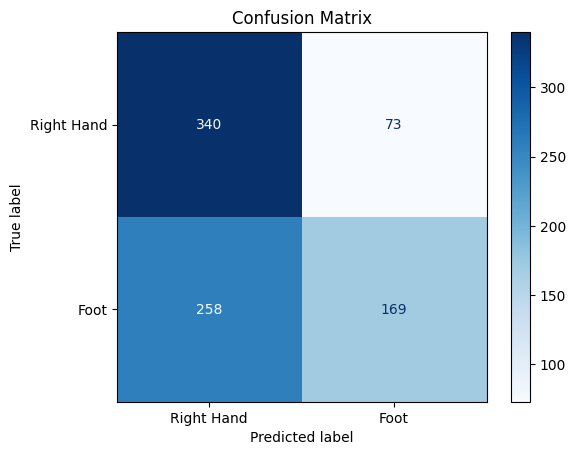

In [ ]:
cm_test = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=["Right Hand", "Foot"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_test, test_pred, target_names=["Right Hand", "Foot"]))


              precision    recall  f1-score   support

  Right Hand       0.57      0.82      0.67       413
        Foot       0.70      0.40      0.51       427

    accuracy                           0.61       840
   macro avg       0.63      0.61      0.59       840
weighted avg       0.63      0.61      0.59       840



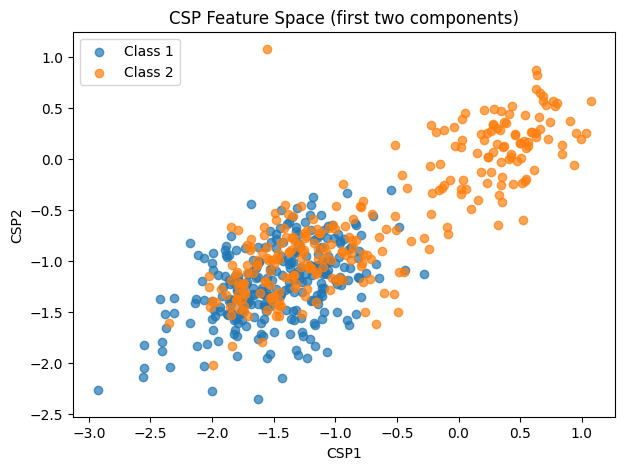

In [30]:
plt.figure(figsize=(7,5))
plt.scatter(csp_features[y_labeled==1,0], csp_features[y_labeled==1,1], label="Class 1", alpha=0.7)
plt.scatter(csp_features[y_labeled==2,0], csp_features[y_labeled==2,1], label="Class 2", alpha=0.7)
plt.title("CSP Feature Space (first two components)")
plt.xlabel("CSP1")
plt.ylabel("CSP2")
plt.legend()
plt.show()


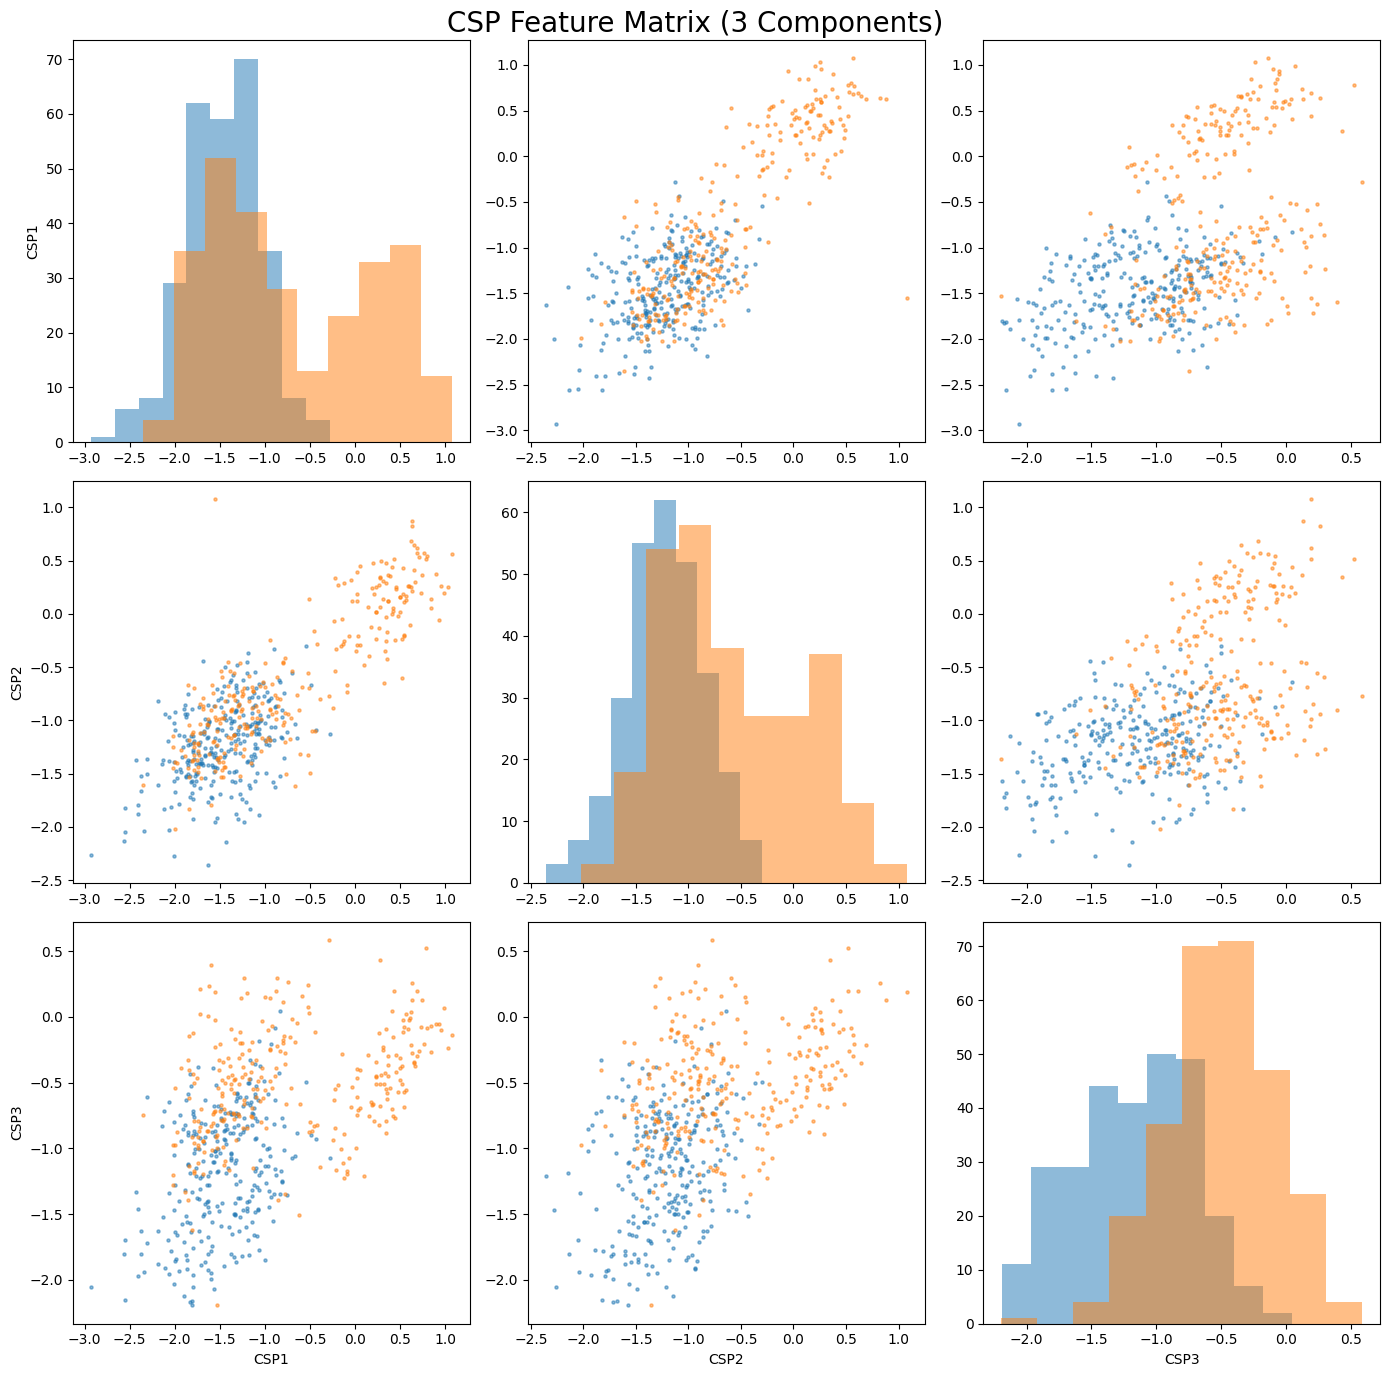

In [31]:
components = 3
fig, axes = plt.subplots(components, components, figsize=(14,14))

for i in range(components):
    for j in range(components):
        ax = axes[i,j]
        if i == j:
            ax.hist(csp_features[y_labeled==1, i], alpha=0.5, label='Class 1')
            ax.hist(csp_features[y_labeled==2, i], alpha=0.5, label='Class 2')
        else:
            ax.scatter(csp_features[y_labeled==1, j],
                       csp_features[y_labeled==1, i],
                       s=5, alpha=0.5)
            ax.scatter(csp_features[y_labeled==2, j],
                       csp_features[y_labeled==2, i],
                       s=5, alpha=0.5)
        if i == components - 1:
            ax.set_xlabel(f"CSP{j+1}")
        if j == 0:
            ax.set_ylabel(f"CSP{i+1}")

plt.suptitle("CSP Feature Matrix (3 Components)", fontsize=20)
plt.tight_layout()
plt.show()


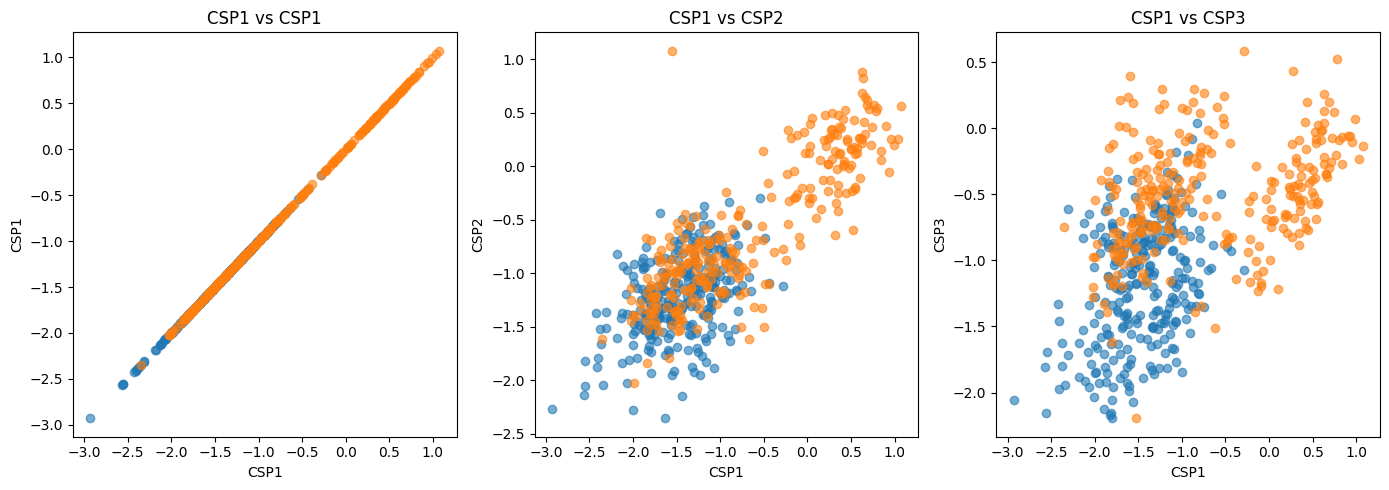

In [32]:
plt.figure(figsize=(14,5))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(csp_features[y_labeled==1,0],
                csp_features[y_labeled==1,i],
                alpha=0.6, label="Class 1")
    plt.scatter(csp_features[y_labeled==2,0],
                csp_features[y_labeled==2,i],
                alpha=0.6, label="Class 2")
    plt.xlabel("CSP1")
    plt.ylabel(f"CSP{i+1}")
    plt.title(f"CSP1 vs CSP{i+1}")

plt.tight_layout()
plt.show()


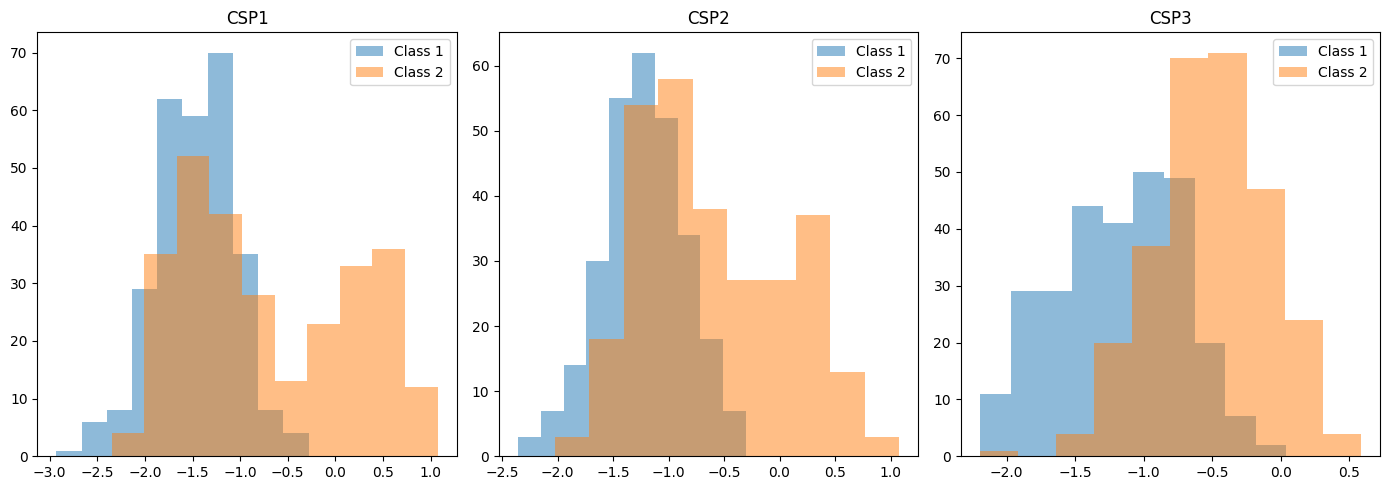

In [33]:
plt.figure(figsize=(14,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(csp_features[y_labeled==1, i], alpha=0.5, label='Class 1')
    plt.hist(csp_features[y_labeled==2, i], alpha=0.5, label='Class 2')
    plt.title(f"CSP{i+1}")
    #if i == 0:
    plt.legend()
plt.tight_layout()
plt.show()
